Посколько в задании не сказано каким образом обучаться, воспользовался обоими методами, генетическим и q-learning

## Genetic

In [12]:
import gym

#create a single game instance
env = gym.make("Taxi-v2")

#start new game
env.reset();

[2017-10-24 20:34:52,705] Making new env: Taxi-v2


In [13]:
# display the game state
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [14]:
print("initial observation code:", env.reset())
print('printing observation:')
env.render()
print("observations:", env.observation_space, 'n=', env.observation_space.n)
print("actions:", env.action_space, 'n=', env.action_space.n)

initial observation code: 491
printing observation:
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

observations: Discrete(500) n= 500
actions: Discrete(6) n= 6


In [15]:
print("taking action 2 (right)")
new_obs, reward, is_done, _ = env.step(2)
print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", is_done)
print("printing new state:")
env.render()

taking action 2 (right)
new observation code: 491
reward: -1
is game over?: False
printing new state:
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


In [16]:
action_to_i = {
    'left':3,
    'down':0,
    'right':2,
    'up':1,
    'pick':4,
    'drop':5,
}

In [17]:
env.step(action_to_i['down'])
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


In [24]:
import numpy as np
n_states = env.observation_space.n
n_actions = env.action_space.n

def get_random_policy():
    """
    Build a numpy array representing agent policy.
    This array must have one element per each of 16 environment states.
    Element must be an integer from 0 to 3, representing action
    to take from that state.
    """
    return np.random.choice(replace=True,a=np.arange(6),size=500)

In [39]:
def sample_reward(env, policy, t_max=100):
    """
    Interact with an environment, return sum of all rewards.
    If game doesn't end on t_max (e.g. agent walks into a wall), 
    force end the game and return whatever reward you got so far.
    Tip: see signature of env.step(...) method above.
    """
    s = env.reset()
    sum_reward = 0
    cur_state = 0
    
    for _ in np.arange(t_max):
        s, reward, is_done, _ = env.step(policy[s])
        sum_reward += reward
        if is_done:
            break
    return sum_reward

In [40]:
def evaluate(policy, n_times=100):
    """Run several evaluations and average the score the policy gets."""
    rewards = [sample_reward(env, policy) for _ in range(n_times)]
    return float(np.mean(rewards))

In [41]:
import scipy.stats as sps
def crossover(policy1, policy2, p=0.5):
    """
    for each state, with probability p take action from policy1, else policy2
    """
    choose = sps.bernoulli.rvs(size=policy1.shape, p=p)
    return np.where(choose, policy1, policy2)

In [42]:
def mutation(policy, p=0.1):
    """
    for each state, with probability p replace action with random action
    Tip: mutation can be written as crossover with random policy
    """
    return crossover(get_random_policy(), policy, p)
    

In [43]:
np.random.seed(1234)
policies = [crossover(get_random_policy(), get_random_policy()) 
            for i in range(10**4)]

assert all([len(p) == n_states for p in policies]), 'policy length should always be 16'
assert np.min(policies) == 0, 'minimal action id should be 0'
assert np.max(policies) == n_actions-1, 'maximal action id should be n_actions-1'

assert any([np.mean(crossover(np.zeros(n_states), np.ones(n_states))) not in (0, 1)
               for _ in range(100)]), "Make sure your crossover changes each action independently"
print("Seems fine!")

Seems fine!


In [48]:
n_epochs = 100 #how many cycles to make
pool_size = 150 #how many policies to maintain
n_crossovers = 50 #how many crossovers to make on each step
n_mutations = 50 #how many mutations to make on each tick

In [49]:
print("initializing...")
pool = [get_random_policy() for _ in np.arange(pool_size)]
pool_scores = [evaluate(policy) for policy in pool]

initializing...


In [50]:
assert type(pool) == type(pool_scores) == list
assert len(pool) == len(pool_scores) == pool_size
assert all([type(score) in (float, int) for score in pool_scores])

In [51]:
#main loop
reward = []
modify = lambda s: "'" + s + "'"
config = "Start Taxi Learning with n_epoches: {}, pool_size: {}, n_crossovers: {}, n_mutations: {}".format(
    n_epochs, pool_size, n_crossovers, n_mutations,
)
print(config)
# config = modify(config)
# !telegram-send $config
for epoch in range(n_epochs):
    epoch_start_msg = "Epoch %s:"%epoch
    print(epoch_start_msg)
#     epoch_start_msg = modify(epoch_start_msg)
#     !telegram-send $epoch_start_msg
    crossovered = [crossover(pool[ind[0]], pool[ind[1]]) 
                   for ind in np.random.choice(a=np.arange(len(pool)), size=2*n_crossovers).reshape((-1, 2))]
    mutated = [mutation(pool[ind]) for ind in np.random.choice(a=np.arange(len(pool)),size=n_mutations)]
    
    #add new policies to the pool
    pool.extend(crossovered)
    pool.extend(mutated)
    pool_scores = [evaluate(policy) for policy in pool]
    
    #select pool_size best policies
    selected_indices = np.argsort(pool_scores)[-pool_size:]
    pool = [pool[i] for i in selected_indices]
    pool_scores = [pool_scores[i] for i in selected_indices]

    #print the best policy so far (last in ascending score order)
    line = "best score: {}".format(pool_scores[-1]) 
    reward.append(pool_scores[-1])
    print(line)
#     line = modify(line)
#     !telegram-send $line
#     print_policy(pool[-1])

Start Taxi Learning with n_epoches: 100, pool_size: 150, n_crossovers: 50, n_mutations: 50
Epoch 0:
best score: -448.93
Epoch 1:
best score: -431.83
Epoch 2:
best score: -431.56
Epoch 3:
best score: -413.92
Epoch 4:
best score: -395.56
Epoch 5:
best score: -405.19
Epoch 6:
best score: -396.1
Epoch 7:
best score: -404.65
Epoch 8:
best score: -368.65
Epoch 9:
best score: -386.83
Epoch 10:
best score: -342.28
Epoch 11:
best score: -386.92
Epoch 12:
best score: -350.92
Epoch 13:
best score: -279.55
Epoch 14:
best score: -350.29
Epoch 15:
best score: -333.1
Epoch 16:
best score: -350.65
Epoch 17:
best score: -349.84
Epoch 18:
best score: -305.47
Epoch 19:
best score: -351.82
Epoch 20:
best score: -332.47
Epoch 21:
best score: -350.92
Epoch 22:
best score: -278.92
Epoch 23:
best score: -296.56
Epoch 24:
best score: -297.64
Epoch 25:
best score: -323.83
Epoch 26:
best score: -297.55
Epoch 27:
best score: -279.19
Epoch 28:
best score: -287.56
Epoch 29:
best score: -297.1
Epoch 30:
best score: 

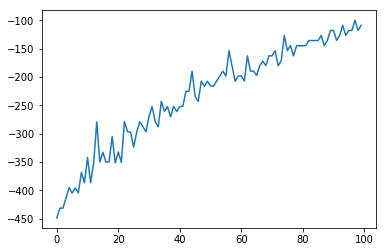

In [52]:
plt.plot(reward)

## Q-learning

In [1]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from IPython.display import clear_output

### Demo on taxi

Here we use the qlearning agent from before on taxi env from openai gym.
You will need to insert a few agent functions here.

In [2]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n

[2017-10-24 17:44:29,019] Making new env: Taxi-v2


In [3]:
from qlearning import QLearningAgent

In [4]:
def play_and_train(env,agent,t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.getAction(s)
        
        next_s, r, done, _ = env.step(a)
        
        agent.update(s, a, next_s, r)

        s = next_s
        
        total_reward += r
        if done:
            break
        
    return total_reward 

8.44
0.40000000000000024
3.885412266959203e-05


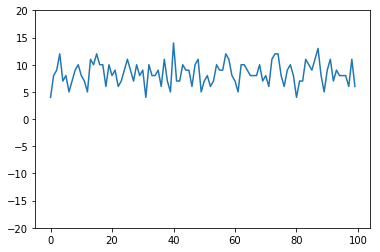

100%|██████████| 100000/100000 [05:47<00:00, 227.11it/s]


In [10]:
rewards = []
alpha_bound = 0.4
agent = QLearningAgent(alpha=0.9,epsilon=0.9,discount=0.5,
                   getLegalActions = lambda s: range(n_actions))

# !telegram-send "Start Taxi Q-learning"

for i in tqdm(np.arange(1000*100) + 1, position=0):
    rewards.append(play_and_train(env,agent))
    
    if i % 100 == 0:
        agent.epsilon *= 0.99
        agent.alpha = alpha_bound + (agent.alpha - alpha_bound) * 0.9
        clear_output(True)
        print(np.mean(rewards[-100:]))
        print(agent.alpha)
        print(agent.epsilon)
        plt.plot(rewards[-100:])
        plt.ylim([-20, 20])
        plt.show()

#     if i % 1000 == 0:
#         info = "'Epoch: {}, epsilon: {:.3f}, lr: {:.3f}, last 1000 rewards mean: {}'".format(int(i/1000), agent.epsilon, agent.alpha, np.mean(rewards[-1000:]))
#         !telegram-send $info
# !telegram-send "Finish Taxi Q-learning"

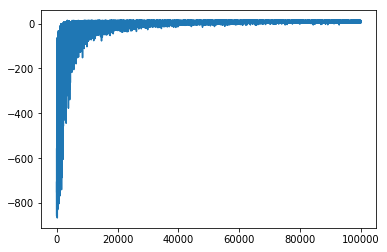

In [11]:
plt.plot(rewards)

In [30]:
'{:.2f}'.format(1.2343214)

'1.23'

In [37]:
sum([np.random.binomial(n=1, p=0.1) for _ in range(100)])

7